# MLS Dynamo - Check Retention Distribution
* StellarAlgo
* Ryan Kazmerik - revised by Peter Morrison
* August 2, 2022 - revision date: August 11, 2022

This needs 2 model files, this doesn't train a model due to M1 Mac constraints.

What you need: place the inference_data.csv for the day you want to check into the data/ folder, rename it to `inference_data_MONTH_DAY.csv`. Then rename the variable below for the date you want to run and run the file.

In [2]:
date_to_run = "july_1"

# set to "" for no subfolder - include if using a sub folder
sub_folder = "dynamo_ticket_debugging/"

In [3]:
import boto3 
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pycaret.classification import *

### Let's grab the training and eval datasets currently in prod:

### Let's setup our new model:

### Let's finalize our new model so it can be used to make predictions:

### Let's also load in the model currently being used in production:

In [5]:
old_model = load_model(f'../../models/{sub_folder}/old_model')
new_model = load_model(f'../../models/{sub_folder}/new_model')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [6]:
df_inference = pd.read_csv(f"../../data/{sub_folder}inference_data_{date_to_run}.csv")
df_inference.columns=['attendancePercent','clientcode','dimcustomermasterid','distToVenue','isNextYear_Buyer','lkupclientid','missed_games_1','missed_games_2','missed_games_over_2','productGrouping','recency','recentDate','renewedBeforeDays','source_tenure','totalSpent','year']

df_inference = df_inference.loc[df_inference['lkupclientid']==13]

In [7]:
df_new_predictions = predict_model(new_model, data=df_inference, raw_score=True)
df_prod_predictions = predict_model(old_model, data=df_inference, raw_score=True)

### Let's try normalizing the scores between a range of 0 and 1:

In [8]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [9]:
df_new_predictions["Score_1"] = df_new_predictions["Score_1"] * 100
df_new_predictions["Score_1"] = NormalizeData(df_new_predictions["Score_1"])

df_new_predictions["Score_1"].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

(0.8, 0.9]       556
(0.7, 0.8]       467
(0.6, 0.7]       351
(0.5, 0.6]       297
(0.9, 1.0]       254
(0.4, 0.5]       220
(-0.001, 0.1]    203
(0.3, 0.4]       176
(0.2, 0.3]       134
(0.1, 0.2]        81
Name: Score_1, dtype: int64

In [10]:
df_prod_predictions["Score_1"] = df_prod_predictions["Score_1"] * 100
df_prod_predictions["Score_1"] = NormalizeData(df_prod_predictions["Score_1"])

df_prod_predictions["Score_1"].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

(0.7, 0.8]       545
(0.6, 0.7]       522
(0.2, 0.3]       313
(0.5, 0.6]       266
(0.1, 0.2]       254
(0.8, 0.9]       238
(0.3, 0.4]       199
(0.4, 0.5]       196
(-0.001, 0.1]    145
(0.9, 1.0]        61
Name: Score_1, dtype: int64

### Let's have a look at the distribution of scores for both models:

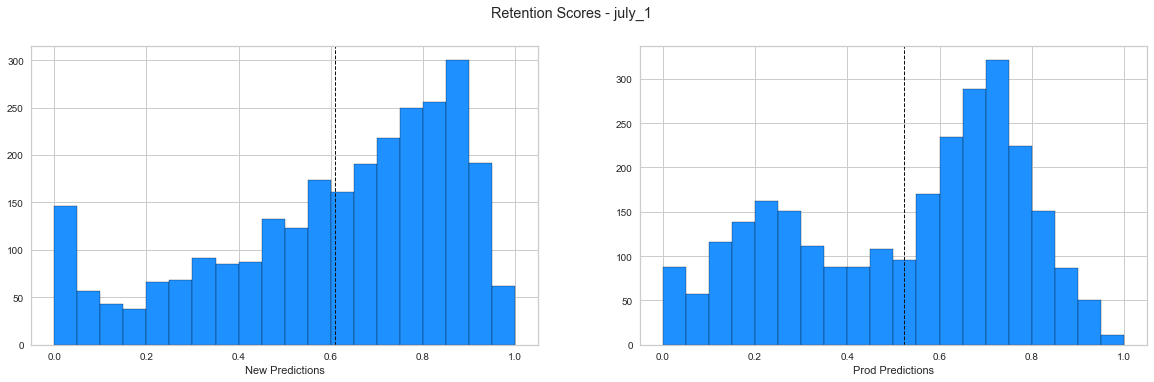

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Retention Scores - {date_to_run}')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')

ax1.axvline(df_new_predictions['Score_1'].mean(), color='k', linestyle='dashed', linewidth=1)
ax2.axvline(df_prod_predictions['Score_1'].mean(), color='k', linestyle='dashed', linewidth=1)

ax1.set_xlabel('New Predictions')
ax2.set_xlabel('Prod Predictions')

fig.figure.set_figwidth(20)

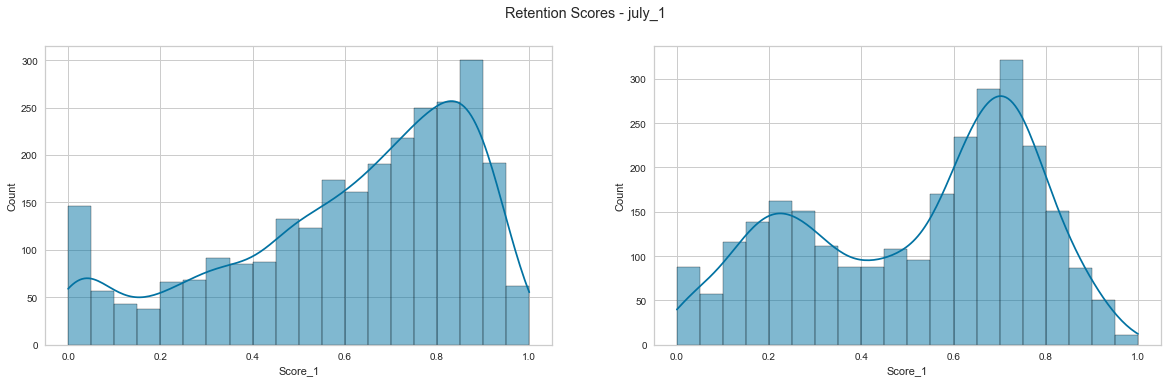

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'Retention Scores - {date_to_run}')

sns.histplot(df_new_predictions['Score_1'], kde=True, bins=20, ax=ax1)
sns.histplot(df_prod_predictions['Score_1'], kde=True, bins=20, ax=ax2)
fig.figure.set_figwidth(20)
fig.show()

In [ ]:
print(f"Old: {df_prod_predictions['Score_1'].mean()}")

print(f"New: {df_new_predictions['Score_1'].mean()}")

Old: 0.5232451398332308
New: 0.6098704245070019


### Done